In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import anndata2ri
# import rpy2

import scvi
import scanpy as sc

from scvi.model import TOTALVI

sc.set_figure_params(figsize=(4, 4))

Global seed set to 0


In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
adata = scvi.data.pbmc_seurat_v4_cite_seq(
    mask_protein_batches=5,
)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

INFO     File data/pbmc_seurat_v4.h5ad already downloaded                                    


In [4]:
sc.pp.highly_variable_genes(
    adata, 
    n_top_genes=4000, 
    flavor="seurat_v3",
    batch_key="orig.ident", 
    subset=True,
    layer="counts"
)

In [5]:
adata

AnnData object with n_obs × n_vars = 152094 × 4000
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'X_index', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Protein log library size', 'Number proteins detected', 'RNA log library size'
    var: 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg'
    obsm: 'protein_counts'
    layers: 'counts'

In [6]:
TOTALVI.setup_anndata(
    adata, 
    layer="counts", 
    batch_key="orig.ident", 
    protein_expression_obsm_key="protein_counts"
)

INFO     Using column names from columns of adata.obsm['protein_counts']                     
INFO     Found batches with missing protein expression                                       


### Run pretrained model

In [7]:
# # training code here
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    n_layers_decoder=2,
    n_layers_encoder=2,
)

vae = TOTALVI(adata, **arches_params)
vae.train(max_epochs=250)
vae.save("seurat_reference_model", overwrite=True)

INFO     Computing empirical prior initialization for protein background.                    


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/scvi/lib/python3.8/site-packages/scvi/model/_totalvi.py:133: UserWarning: Some proteins have all 0 counts in some batches. These proteins will be treated as missing measurements; however, this can occur due to experimental design/biology. Reinitialize the model with `override_missing_proteins=True`,to override this behavior.
  warnings.warn(msg, UserWarning)
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/scvi/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.util

Epoch 1/250:   0%|          | 0/250 [00:00<?, ?it/s]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/scvi/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:100: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/icb/soroor.hediyeh-zadeh/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  + lgamma(x + theta)
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/scvi/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function

Epoch 250/250: 100%|██████████| 250/250 [1:15:19<00:00, 18.08s/it, loss=611, v_num=1]


In [8]:
vae = TOTALVI.load("seurat_reference_model", adata=adata,backup_url=None)

INFO     File seurat_reference_model/model.pt already downloaded                             
INFO     Found batches with missing protein expression                                       
INFO     Computing empirical prior initialization for protein background.                    


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/scvi/lib/python3.8/site-packages/scvi/model/_totalvi.py:133: UserWarning: Some proteins have all 0 counts in some batches. These proteins will be treated as missing measurements; however, this can occur due to experimental design/biology. Reinitialize the model with `override_missing_proteins=True`,to override this behavior.
  warnings.warn(msg, UserWarning)


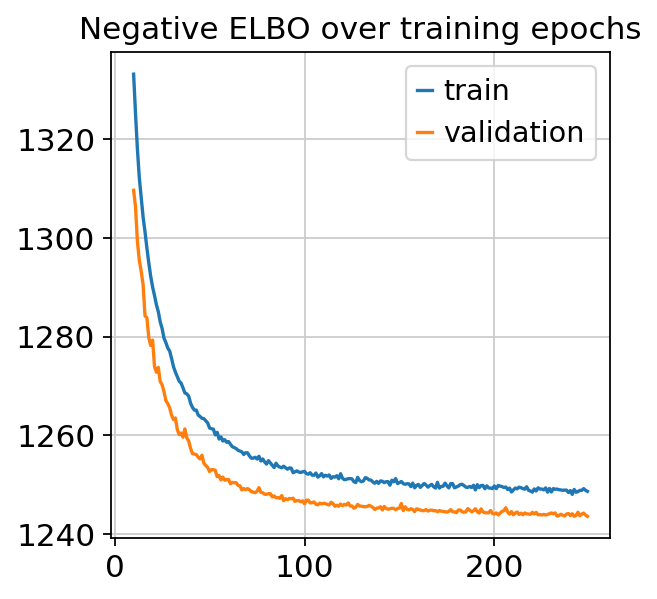

In [9]:
plt.plot(vae.history["elbo_train"].iloc[10:], label="train")
plt.plot(vae.history["elbo_validation"].iloc[10:], label="validation")
plt.title("Negative ELBO over training epochs")
plt.legend()

In [10]:
adata.obsm["X_totalvi_scarches"] = vae.get_latent_representation()

In [11]:
import umap

X = adata.obsm["X_totalvi_scarches"]
trans = umap.UMAP(
    n_neighbors=10, 
    random_state=42,
    min_dist=0.4,
)
adata.obsm["X_umap"] = trans.fit_transform(X)

vae.umap_op_ = trans

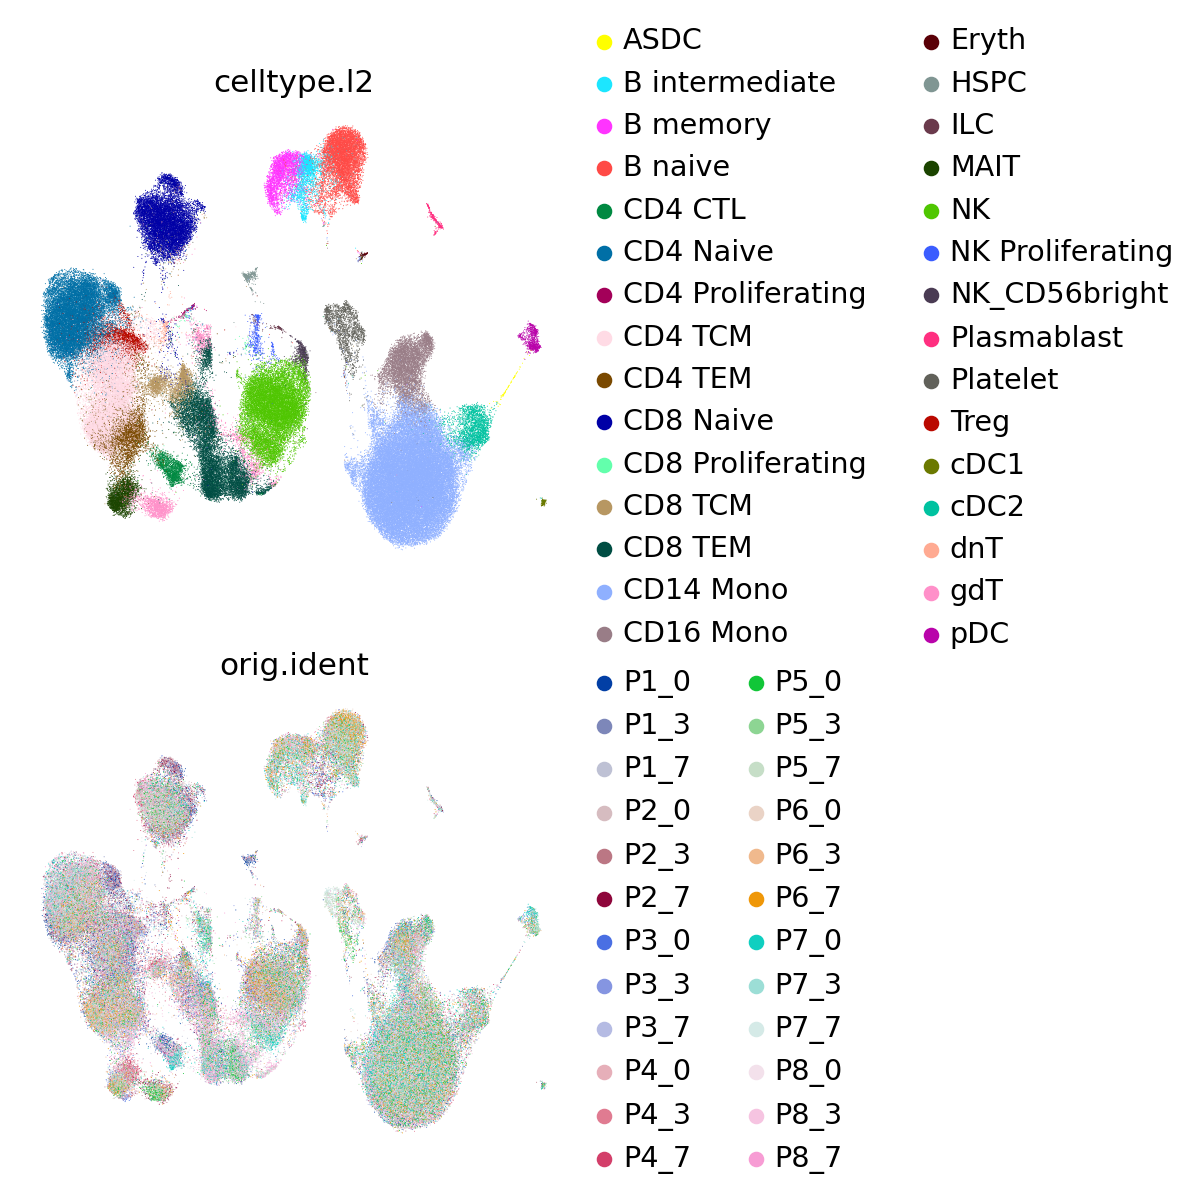

In [12]:
sc.pl.umap(
    adata, 
    color=["celltype.l2", "orig.ident"], 
    frameon=False,
    ncols=1,
)

### Map query data

In [13]:
query = sc.read("data/covid_cite.h5ad", backup_url="https://ndownloader.figshare.com/files/27458837")

In [15]:
import scrublet as scr

query.obs["doublet_scores"] = 0
query.obs["predicted_doublets"] = True
for s in np.unique(query.obs["set"]):
    mask = query.obs["set"] == s
    counts_matrix = query[mask].X.copy()
    scrub = scr.Scrublet(counts_matrix)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    query.obs["doublet_scores"].iloc[mask] = doublet_scores
    query.obs["predicted_doublets"].iloc[mask] = predicted_doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.36
Detected doublet rate = 3.8%
Estimated detectable doublet fraction = 41.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.2%
Elapsed time: 85.1 seconds


/tmp/ipykernel_82719/4043290043.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query.obs["doublet_scores"].iloc[mask] = doublet_scores
/tmp/ipykernel_82719/4043290043.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query.obs["predicted_doublets"].iloc[mask] = predicted_doublets


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.24
Detected doublet rate = 6.4%
Estimated detectable doublet fraction = 57.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 11.2%
Elapsed time: 84.5 seconds


/tmp/ipykernel_82719/4043290043.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query.obs["predicted_doublets"].iloc[mask] = predicted_doublets


In [16]:
query.layers["counts"] = query.X.copy()
sc.pp.normalize_total(query, target_sum=1e4)
sc.pp.log1p(query)
query.raw = query
# subset to reference vars
query = query[:, adata.var_names].copy()

query.obsm["protein_counts"] = query.obsm["pro_exp"].copy()
query.obs["celltype.l2"] = "Unknown"
query.obs["orig.ident"] = query.obs["set"]
query.obsm["X_umap"] = query.obs[["UMAP1", "UMAP2"]]

# reorganize query proteins, missing proteins become all 0
for p in adata.obsm["protein_counts"].columns:
    if p not in query.obsm["protein_counts"].columns:
        query.obsm["protein_counts"][p] = 0.0
# ensure columns are in same order
query.obsm["protein_counts"] = query.obsm["protein_counts"].loc[:, adata.obsm["protein_counts"].columns]

/tmp/ipykernel_82719/2379243673.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  query.obsm["protein_counts"][p] = 0.0
/tmp/ipykernel_82719/2379243673.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  query.obsm["protein_counts"][p] = 0.0
/tmp/ipykernel_82719/2379243673.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

In [17]:
adata.obs["dataset_name"] = "Reference"
query.obs["dataset_name"] = "Query"

In [18]:
from sklearn.ensemble import RandomForestClassifier

y_train = adata.obs["celltype.l2"].astype("category").cat.codes.to_numpy()
X_train = adata.obsm["X_totalvi_scarches"]
clf = RandomForestClassifier(
    random_state=1, 
    class_weight = "balanced_subsample",
    verbose=1,
    n_jobs=-1,
)
clf.fit(X_train, y_train)

vae.latent_space_classifer_ = clf

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   46.7s finished


In [19]:
vae_q = TOTALVI.load_query_data(
    query, 
    vae,
)
vae_q.train(
    max_epochs=150, 
    plan_kwargs=dict(
        weight_decay=0.0,
        scale_adversarial_loss=0.0
    ),
)


INFO     Found batches with missing protein expression                                       
INFO     Computing empirical prior initialization for protein background.                    


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/scvi/lib/python3.8/site-packages/scvi/model/_totalvi.py:133: UserWarning: Some proteins have all 0 counts in some batches. These proteins will be treated as missing measurements; however, this can occur due to experimental design/biology. Reinitialize the model with `override_missing_proteins=True`,to override this behavior.
  warnings.warn(msg, UserWarning)
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/scvi/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.util

Epoch 1/150:   0%|          | 0/150 [00:00<?, ?it/s]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/scvi/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/scvi/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: 

Epoch 150/150: 100%|██████████| 150/150 [16:16<00:00,  6.51s/it, loss=499, v_num=1]


In [20]:
query.obsm["X_totalvi_scarches"] = vae_q.get_latent_representation(query)

### Query celltype prediction

In [21]:
# predict cell types of query
predictions = (
    vae_q.latent_space_classifer_.predict(
        query.obsm["X_totalvi_scarches"]
    )
)
categories = adata.obs["celltype.l2"].astype("category").cat.categories
cat_preds = [categories[i] for i in predictions]
query.obs["celltype.l2"] = cat_preds
query.obs["predicted_l2_scarches"] = cat_preds

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.8s finished


In [22]:
# sc.pl.umap(
#     query, 
#     color=["celltype.l2", "final_clust_review"], 
#     frameon=False,
#     ncols=1,
# )

In [23]:
query.obsm["X_umap_project"] = vae_q.umap_op_.transform(
    query.obsm["X_totalvi_scarches"]
)

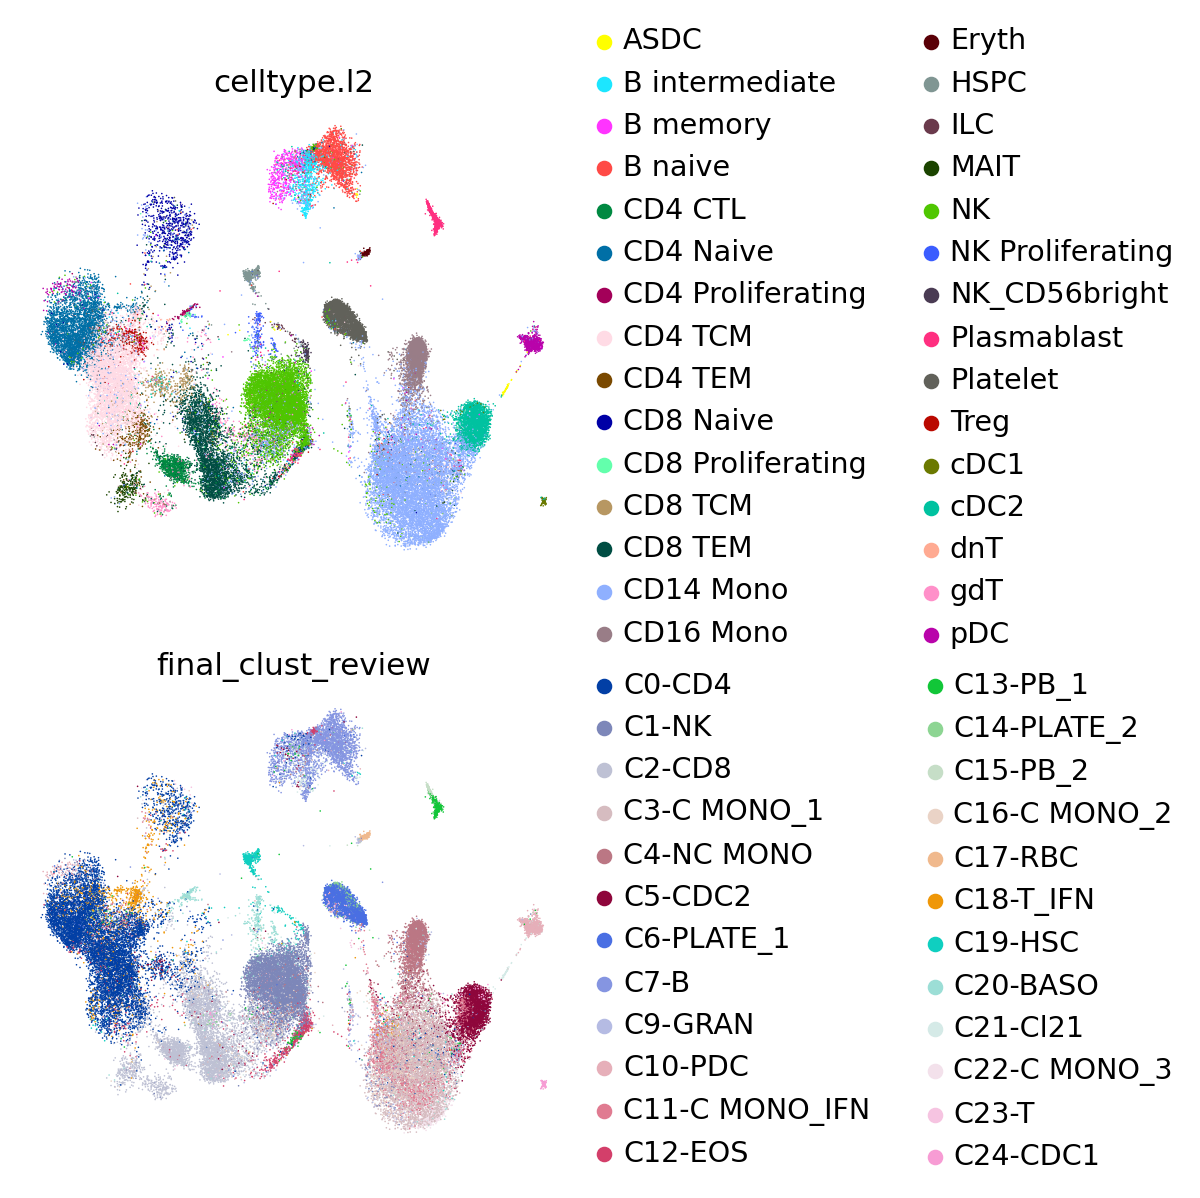

In [24]:
sc.pl.embedding(
    query,
    "X_umap_project",
    color=["celltype.l2", "final_clust_review"], 
    frameon=False,
    ncols=1,
)

In [25]:
umap_adata = sc.AnnData(
    np.concatenate(
        [
         query.obsm["X_umap_project"], 
         adata.obsm["X_umap"], 
        ],
        axis=0
    )
)
umap_adata.obs["celltype"] = np.concatenate(
    [
     query.obs["celltype.l2"].values,
     adata.obs["celltype.l2"].values
    ]
)
umap_adata.obs["dataset"] = np.concatenate(
    [
     query.shape[0] * ["query"],
     adata.shape[0] * ["reference"]
    ]
)
umap_adata.obsm["X_umap"] = umap_adata.X

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/scvi/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


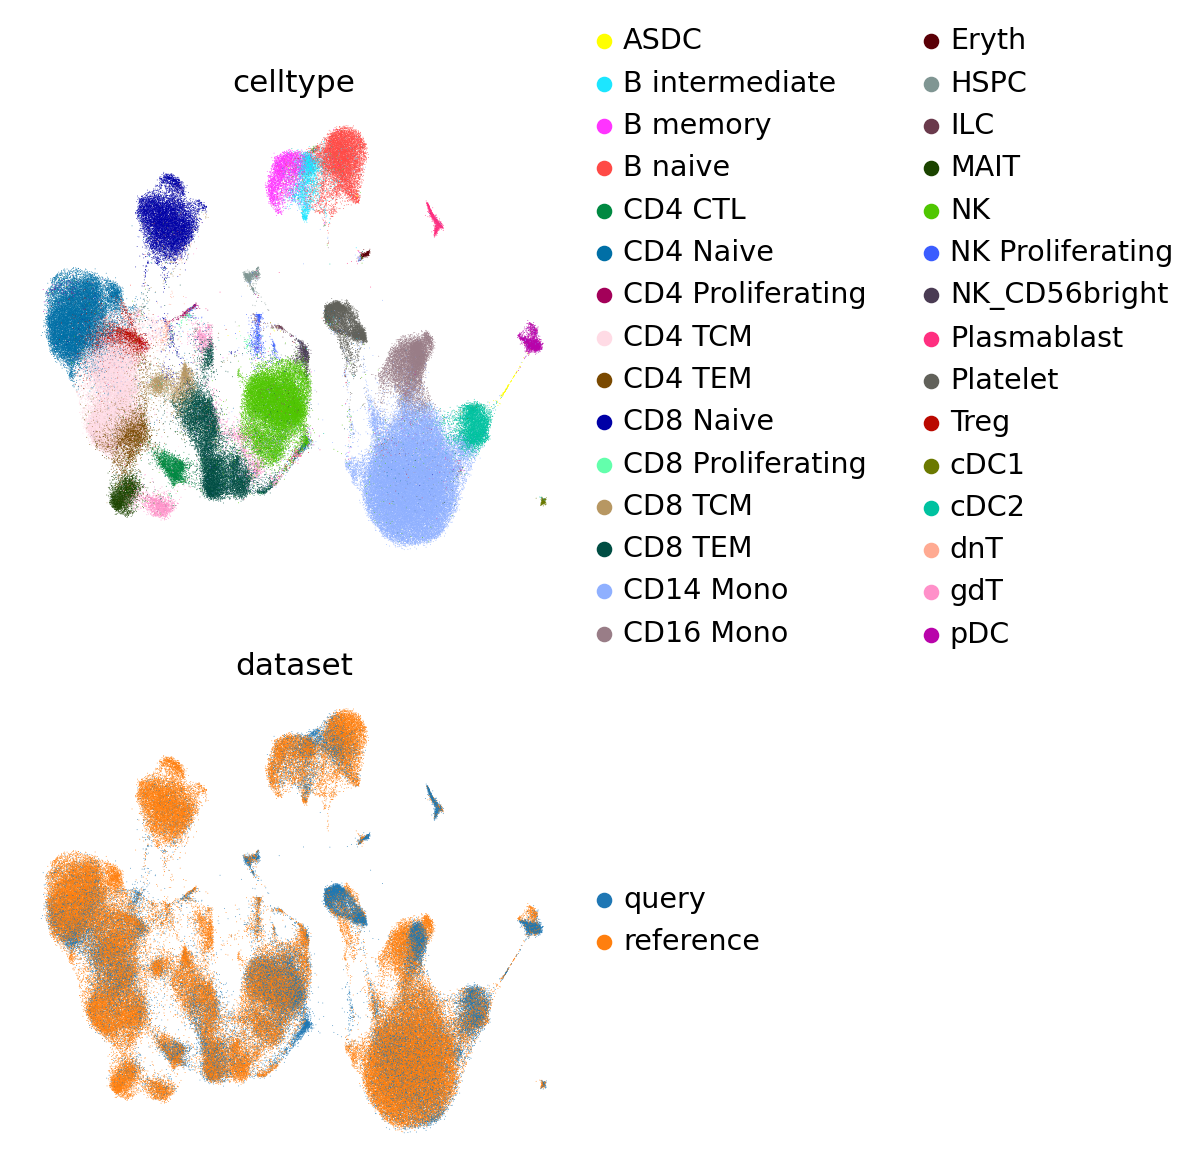

In [26]:
inds = np.random.permutation(np.arange(umap_adata.shape[0]))
sc.pl.umap(
    umap_adata[inds],
    color=["celltype", "dataset"], 
    frameon=False,
    ncols=1,
)

In [27]:
umap_adata

AnnData object with n_obs × n_vars = 209763 × 2
    obs: 'celltype', 'dataset'
    obsm: 'X_umap'

In [28]:
umap_adata.write('totalVI_cite_pbmc_integrated.h5ad')

In [29]:
query.write('totalVI_cite_pbmc_query.h5ad')

In [30]:
adata.write('totalVI_cite_pbmc_ref.h5ad')